# H&M Personalized Fashion Recommendations

## Purpose

To develop product recommendations based on data from previous transactions and product and customer metadata. Using ML techniques, we will build a model to predict what articles each customer will purchase in the following 7-day period.  Customers who didn't make a purchase will be excluded from scoring.  

## Datasets
- articles.csv 
    - appearance
    - product family
    - name
- customers.csv
    - club status 
    - age
    - postal code
- transactions_train.csv
    - data to train the completed model on

In [54]:
# set up paths and create datasets
import os
import pandas as pd
from dask import dataframe as dframe # the training dataset is hugenormous so we'll let dask handle it

# create paths based on current working directory
data_folder = os.path.join(os.getcwd(), 'data')
hm_datasets = os.path.join(data_folder, 'h-and-m-personalized-fashion-recommendations')
print(os.listdir(hm_datasets))

# convert csv files to dataframes
customers = pd.read_csv(os.path.join(hm_datasets, 'customers.csv'))
articles = pd.read_csv(os.path.join(hm_datasets, 'articles.csv'))
submission = pd.read_csv(os.path.join(hm_datasets, 'sample_submission.csv'))
txs = dframe.read_csv(os.path.join(hm_datasets,'transactions_train.csv'))

['customers.csv', 'sample_submission.csv', 'transactions_train.csv', 'articles.csv']


In [55]:
submission.iloc[0][1] # sample view of prediction for formatting

'0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'

In [56]:
customers.isna().sum() # get null counts per column

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

In [57]:
clean_cust = customers.copy(deep=True) # copy df to clean values
clean_cust.nunique()

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          4
age                            84
postal_code                352899
dtype: int64

In [58]:
clean_cust[['FN','Active']] = clean_cust[['FN','Active']].fillna(value=0) # FN and Active are binary - either True or False

clean_cust.club_member_status.value_counts(dropna=False)

ACTIVE        1272491
PRE-CREATE      92960
NaN              6062
LEFT CLUB         467
Name: club_member_status, dtype: int64

In [59]:
clean_cust.club_member_status.fillna('NEVER',inplace=True) # assuming if null, never joined club

clean_cust.fashion_news_frequency = clean_cust.fashion_news_frequency.str.upper() # normalize text to uppercase
clean_cust.fashion_news_frequency.value_counts(dropna=False)

NONE         877713
REGULARLY    477416
NaN           16009
MONTHLY         842
Name: fashion_news_frequency, dtype: int64

In [60]:
clean_cust[clean_cust.fashion_news_frequency == 'NONE'][['FN','Active']].value_counts() # FN by None

FN   Active
0.0  0.0       876922
1.0  1.0          500
     0.0          291
dtype: int64

In [61]:
clean_cust[clean_cust.fashion_news_frequency.isna()][['FN','Active','club_member_status']].value_counts() # FN by Null

FN   Active  club_member_status
0.0  0.0     ACTIVE                11925
             PRE-CREATE             2049
             NEVER                  2035
dtype: int64

We see 500 instances where `FN`, `Active`, and `club_member_status` all indicate active membership, however `fashion_news_frequency` is `NONE`.  In order to understand the best way to handle null values we need to understand if these rows are erroneous and removable, and thus NaN values can be called None, or if another value should be used in place.  After running through the signup form for the fashion news frequency, there is no clear indication for what `REGULARLY` or `MONTHLY` mean in this context. 

Given the relavitely small number of nulls, it may make sense to drop the rows where `FN` or `Active` are 1 and `fashion_news_frequency` is `NONE` and impute all NaN values to equal 0.  This should help to reduce potential noise as we move forward.

In [62]:
clean_cust = clean_cust.drop(clean_cust[(clean_cust.fashion_news_frequency == 'NONE') & (clean_cust.FN == 1.0)].index)
clean_cust.fashion_news_frequency = clean_cust.fashion_news_frequency.fillna(0)

clean_cust.isna().sum() # remaining null counts

customer_id                   0
FN                            0
Active                        0
club_member_status            0
fashion_news_frequency        0
age                       15853
postal_code                   0
dtype: int64

Age will be a little harder to handle null values, as it has a larger number of values on an interval scale.  A couple ways we can handle this are:
* impute by mean of distribution (only effective if age follows a gaussian distribution)
* drop all nulls (could potentially lose a significant amount of data)
* Predictive Mean Matching (fits better to non-normal distributions)

Before we can choose a method we'll have to see what the effects will be of choosing any.

In [63]:
# potential information loss if we drop null values
print('information loss: {:.2%}'.format(clean_cust.age.isna().sum() / len(clean_cust)))

information loss: 1.16%


mean age: 36.39
median age: 32.00
mode age: 21.00


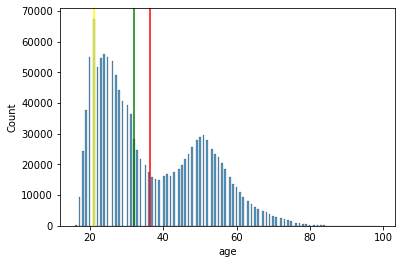

In [64]:
# age distribution
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.histplot(clean_cust, x='age')
plt.axvline(clean_cust.age.mean(), color='red')
plt.axvline(clean_cust.age.median(), color='green')
plt.axvline(clean_cust.age.mode()[0], color='yellow')

print(f'mean age: {clean_cust.age.mean():.2f}')
print(f'median age: {clean_cust.age.median():.2f}')
print(f'mode age: {clean_cust.age.mode()[0]:.2f}')

Because the distribution above is non-normal, we cannot use mean imputation since the mean will tend to fill in the 'valley' of the data, where it is actually less likely compared to either 'peak'. Therefore, we will select an algorithm  to impute the data matching the current distribution as best we can.

For this we can use XGBoost and MICE.  XGBoost is a fast tree-based classifier algorithm useful for large amounts of data.  MICE stands for Multiple Imputation by Chained Equations.  It works by imputing missing data using an iterative series of predictive models, using other variables in the dataset to make predictions until the values converge.  If the variables are totally independent, then the results likely will not be accurate and should be validated.  

In [65]:
clean_cust.iloc[:,1:-2] = clean_cust.iloc[:,1:-2].astype('str')
clean_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1371189 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371189 non-null  object 
 1   FN                      1371189 non-null  object 
 2   Active                  1371189 non-null  object 
 3   club_member_status      1371189 non-null  object 
 4   fashion_news_frequency  1371189 non-null  object 
 5   age                     1355336 non-null  float64
 6   postal_code             1371189 non-null  object 
dtypes: float64(1), object(6)
memory usage: 83.7+ MB


Prior to imputing age, we have to transform our categorical data to numerical instead of string data so the model is able to interpret it correctly.  Since we have a number of distinct categorical variables, One Hot Encoding is appropriate. 

In [66]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
import numpy as np


features = clean_cust.columns[1:-2]
transformed = clean_cust.copy().drop(columns=features)

ohc = OneHotEncoder()
ohc.fit(clean_cust[features])

final_df = transformed.merge(pd.DataFrame(ohc.transform(clean_cust[features]).toarray(), columns=ohc.get_feature_names_out()), on=transformed.index)

ohc.get_feature_names_out()

final_df.head()

,key_0,customer_id,age,postal_code,FN_0.0,FN_1.0,Active_0.0,Active_1.0,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NEVER,club_member_status_PRE-CREATE,fashion_news_frequency_0,fashion_news_frequency_MONTHLY,fashion_news_frequency_NONE,fashion_news_frequency_REGULARLY
0,0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
impute_age = final_df.drop(columns=['key_0','customer_id','postal_code'])

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iimp = IterativeImputer()
iimp.fit(impute_age)



IterativeImputer()

In [68]:
im_age = iimp.transform(impute_age)[:, 0]
clean_cust['age'] = im_age

36.41461799190471 32.0 21.0


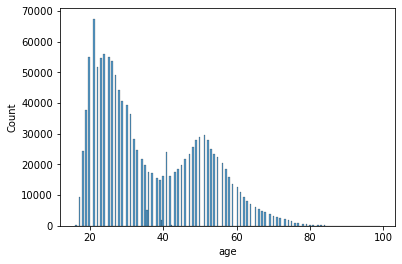

In [69]:
%matplotlib inline
sns.histplot(data = clean_cust['age'])
print(clean_cust.age.mean(), clean_cust.age.median(), clean_cust.age.mode()[0])

Now that we've cleaned up the customer data we can start building out the dataset to make predictions. 

In [70]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


# Exploring the Data

## Building a dataset

We'll start by grouping customers based on certain characteristics.  Some of these could include:
- total spend
- number of items purchased 
- types of items purchased
- demographics (postal code, age, fn status, club membership) 

From there we can start taking <a href=https://www.investopedia.com/ask/answers/032615/what-are-some-examples-stratified-random-sampling.aspstratified> stratified samples </a> or begin <a href=https://en.wikipedia.org/wiki/Cluster_analysis> analyzing clusters </a> where patterns of purchases may emerge.  Since we need to build the model on a subset of the data, we need to ensure that we can capture a representative sample while avoiding overfitting.

In [72]:
# how many unique customers are in the training dataset? 
len(set(txs['customer_id']))

1362281

In [73]:
# is it equivalent to the number of customers in the customers dataset?
len(clean_cust)

1371189

In [75]:
# take a 10% customer sample from transactions
r_state = 10

sample_10 = clean_cust.sample(frac=.1,random_state = r_state) # take 10% random sample of customer ids
dask_10 = txs[txs['customer_id'].isin(sample_10['customer_id'])].compute() # filter the dataset to just sampled customers

In [76]:
print(articles.columns)

name_filter = [word for word in articles.columns if 'name' in word] # list comprehension (the cool way)

# test_names = [] # regular way (not as cool)
# for word in articles.columns:
#     if 'name' in word:
#         test_names.append(word)
# test_nanes

# find the count of unique values for each column in articles dataframe

article_names = articles[name_filter].copy()

for col in article_names:
    print(col, article_names[col].nunique())
    
articles[['product_code','prod_name']].nunique()

colors = [word for word in name_filter if 'colour' in word]

articles[colors].head()

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')
prod_name 45875
product_type_name 131
product_group_name 19
graphical_appearance_name 30
colour_group_name 50
perceived_colour_value_name 8
perceived_colour_master_name 20
department_name 250
index_name 10
index_group_name 5
section_name 56
garment_group_name 21


,colour_group_name,perceived_colour_value_name,perceived_colour_master_name
0,Black,Dark,Black
1,White,Light,White
2,Off White,Dusty Light,White
3,Black,Dark,Black
4,White,Light,White


It looks like product code and name might be a messy column to use, for example there is a value `Strap Top` as well as `Strap Top (1)` which share the same product code, however there are about 1500 more unique product codes vs names.  It would therefore add more noise to our model than useful information to try and wrangle that, when the combination of other columns as well as unique article ID would be sufficient. We can now drop product name from our filter. 

In [77]:
dask_10.groupby(['customer_id']).count()

,t_dat,article_id,price,sales_channel_id
customer_id,,,,
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,3,3,3,3
0000d6c053fc8f9389d4565051f12402d5774aa4a9d2e5c2d5cd5f5f3c9a4488,7,7,7,7
0000ffa57a8098a6cd99c0f0782b3e674f47d68db69dc173c7e67e0f68170c4c,3,3,3,3
0001177027259b455f979d85a278e4b280205d4de5cce4bb83ccbb8d5dbb4b92,37,37,37,37
00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d60c6d7be26f06264d6,41,41,41,41
...,...,...,...,...
fffe61b99c2d0418ed22190a8490b142247e8897c67941ce25f78a99656e9f63,1,1,1,1
fffe8c175c550b9c7d994efcef320737723a43bedf360d7b7c5709cc232b1608,5,5,5,5
fffeb8c2b8b5541865aa6ecd68d65dbe3f17dc93e2776d37b233438c94d9dd12,3,3,3,3


In [78]:
# classifying a single customers's purchases
cust_1 = dask_10[dask_10['customer_id'] == 'ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264'].copy()

training_cols = ['article_id','price','product_code','product_type_no','graphical_appearance_no',
                'colour_group_code','perceived_colour_value_id','perceived_colour_master_id','department_no',
                'index_code','index_group_no','section_no','garment_group_no']

combined = cust_1.merge(articles,on="article_id")
combined.columns

Index(['t_dat', 'customer_id', 'price', 'sales_channel_id', 'article_id',
       'product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')